# AST 384C - Computational Astrophysics - HW 3
## Carlos Jurado

In [1]:
# Python package imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import time
import scipy.spatial 
from pyro import Pyro

# Loading in style file for plots
plt.style.use('/Users/caj3577/Desktop/plotting.mplstyle')

# Problem 1: using KTrees

Set up a code that can generate (uniform) random postions in 3D for a set of N equal-mass
particles in the range [0, 100] in each dimesion. Make sure to use a random number
generator with a seed state that you can specify so that these initial positions are repeatable
exactly.
calculate the acceleration of every particle assuming vacuum boundary conditions (i.e., you
don’t have to worry about periodic boundaries or anything like that) both directly and
using a KDTree for N ∈103,4,5,6. How does the timing scale for each method? Do your
calculations depend on the method you used?

If we let $GM = 1$ in arbitrary units, then the acceleration felt by a particle at position, $r_i$, is given as:

$$ 
\vec{a_i} = \sum_{j=0}^{N} \left( \frac{-\vec{r_{ij}}}{|\vec{r_{ij}}|^3}\right), i \neq j
$$

Initially, I wrote my direct and KDtree method of calculating the acceleration of the particles using nested for-loops. By 10^4 particles, the code had been very inefficient. I have since restructured my code to be vectorized and it has improved the computational speeds up to 10^4 particles. I am still having difficulty running the code for the 10^5 particle case. 

In [2]:

np.random.seed(1234) #initalize random seed for reproducibility

N_arr = [10**3, 10**4, 10**5]

#i - represents an individual particle 
#j - represents a pair interaction on the ith particle 

for N in N_arr:

    #Create the numpy array structure to hold the position (acceleration) vectors for all particles
    r_vecs, acceleration_vecs = np.random.uniform(0,100,size=(N, 3)), np.zeros((N, 3)) 
    #print(r_vecs.shape)
    # Create the numpy array structure to hold the displacement (magnitudes) for all particles from one another
    displacement_vecs,  distances = np.zeros((N, N, 3)), np.zeros((N, N))    
    #print(displacement_vecs.shape)

    start_time = time.time()
    
    ###for i in range(N): #loop through each particle
        ###for j in range(N): #loop through each interaction acting on a given particle

            #Calculate the displacement between a particle and one of the other particles
            ###displacement_vecs[i,j] = r_vecs[j] - r_vecs[i] 

            #compute the distance from the displacement vector
            ###distances[i,j] = np.sqrt(displacement_vecs[i,j,0]**2 + displacement_vecs[i,j,1]**2 + displacement_vecs[i,j,2]**2) 

    displacement_vecs = r_vecs[:, np.newaxis, :] - r_vecs[np.newaxis, :, :]
    distances = np.linalg.norm(displacement_vecs, axis=2)

    #ignore the self-interaction term
    ###mask = distances[i] > 0
    #calculate the sum of the accelerations on one particle due to all of the other particles
    ###acceleration_vecs[i] = np.sum( displacement_vecs[i][mask] * (1.0 / distances[i][mask]**3)[:, np.newaxis], axis=0 ) 

    mask = distances > 0 
    distances_nonzero = np.where(mask, distances, 1)  # Replace zeros with 1 to avoid division by zero
    acceleration_vecs = np.sum(displacement_vecs * ((1.0 / distances_nonzero**3) * mask)[:, :, np.newaxis], axis=1)
    end_time = time.time()

    print(f"Directly: The time taken to setup {N} particles is {np.round(end_time - start_time,2)} seconds")



    ###Below is the KD Tree Implementation 
    start_time = time.time() 
    acceleration_vecs_KD = np.zeros((N, 3))
    displacement_vecs_KD, distances_KD = np.zeros((N, N, 3)), np.zeros((N, N))

    my_KD = scipy.spatial.cKDTree(r_vecs) #initalize my KD tree
    for i in range(N):
        # calculate the distance of the nearest neighbor for the N nearests neighbors. In other words, I am getting back 
        # a ascending ordered list of distances for particle pairings on the ith particle
        distances_KD[i], indices = my_KD.query(r_vecs[i], k=N) 

        ###for j in range(N):
            #Calculate the displacement vectors between a particle and all other particles 
            ###displacement_vecs_KD[i,j] = r_vecs[j] - r_vecs[i]    
    displacement_vecs_KD = r_vecs[:, np.newaxis, :] - r_vecs[np.newaxis, :, :]


        ###mask = distances_KD[i] > 0 #ignore the self-interaction term
    mask = distances_KD > 0 

        #calculate the sum of the accelerations on one particle due to all of the other particles
        ###acceleration_vecs[i] = np.sum( displacement_vecs_KD[i][mask] * (1.0 / distances_KD[i][mask]**3)[:, np.newaxis], axis=0 ) 
    distances_nonzero = np.where(mask, distances_KD, 1)  # Avoid division by zero
    acceleration_vecs_KD = np.sum(displacement_vecs_KD * ((1.0 / distances_nonzero**3) * mask)[:, :, np.newaxis], axis=1)

    end_time = time.time()

    print(f"KD Tree: The time taken to setup {N} particles is {np.round(end_time - start_time,2)} seconds")

    print('=====================NEW ITERATION==========================')
    


Directly: The time taken to setup 1000 particles is 0.11 seconds
KD Tree: The time taken to setup 1000 particles is 0.22 seconds
=====================NEW ITERATION==========================
Directly: The time taken to setup 10000 particles is 7.96 seconds
KD Tree: The time taken to setup 10000 particles is 26.67 seconds
=====================NEW ITERATION==========================


# Problem 2: hydro solvers

Play around with it and have a look at the code – especially riemann.py, which will really
help you understand how the Riemann problem is implemented and solved.

• Run the Kelvin-Helmholtz tests for the 4 hydro solvers exactly as in the code guide.

• Now repeat this with a relative velocity of ±10 instead of 1. Describe the differences, if
any, and their origin, relative to the u =±1 case.
1


Simulation with gamma=1.7 and Delta U = 1 km/s using compressible.


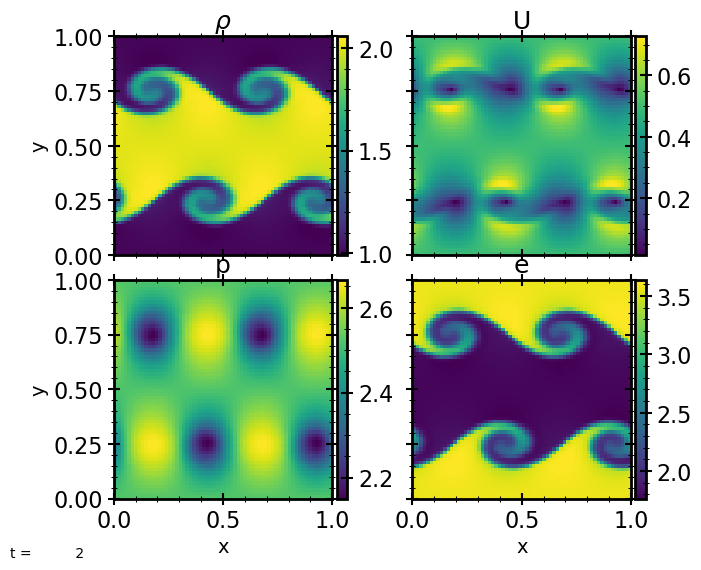

Simulation with gamma=1.7 and Delta U = 1 km/s using compressible_rk.


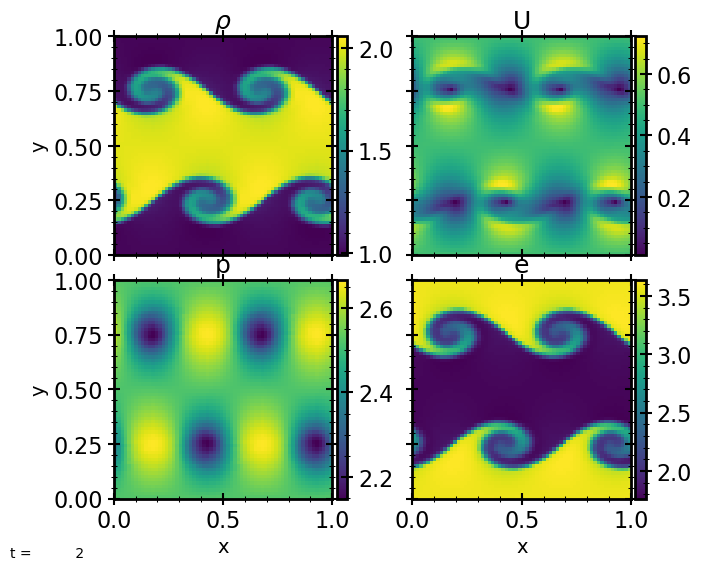

Simulation with gamma=1.7 and Delta U = 1 km/s using compressible_fv4.


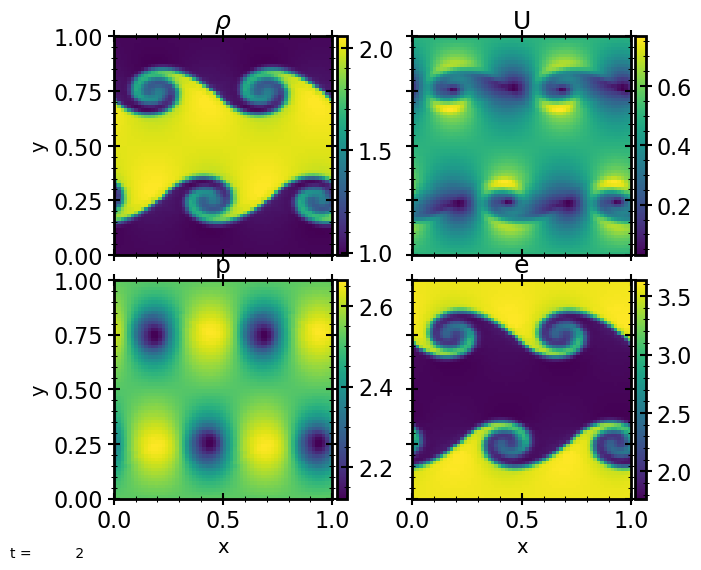

warning, key: compressible.limiter not defined
Simulation with gamma=1.7 and Delta U = 1 km/s using compressible_sdc.


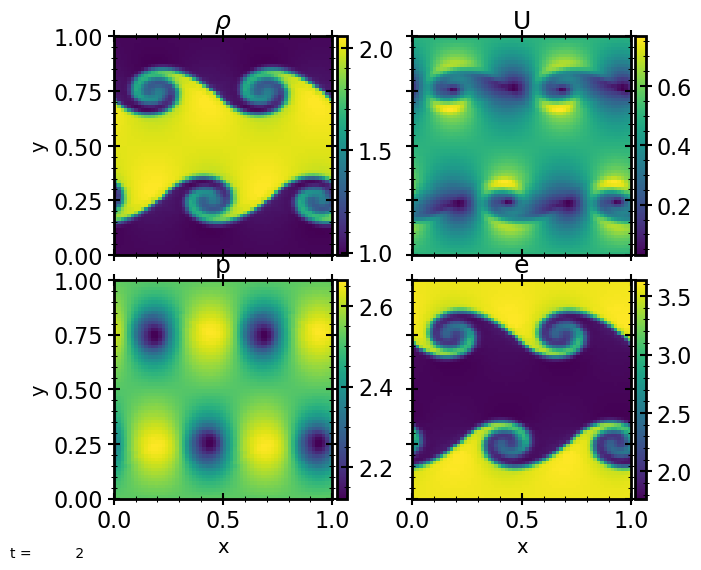

<Figure size 800x600 with 0 Axes>

In [2]:
first_solvers = ["compressible", "compressible_rk", "compressible_fv4", "compressible_sdc"] #list of the hydro solvers to use
first_problem_name = "kh"
first_param_file = "inputs.kh" #reference the input parameter file
first_extra_parameters = {'eos.gamma': 1.7} #input parameters to change

for solver in first_solvers:
    pyro_sim = Pyro(solver) #create a Pyro object
    pyro_sim.initialize_problem(first_problem_name, inputs_file=first_param_file, inputs_dict=first_extra_parameters) #initalize a Pyro object with the input parameters
    #print(pyro_sim)
    pyro_sim.run_sim() #time evolve the simulation
    print(f"Simulation with gamma=1.7 and Delta U = 1 km/s using {solver}.")
    pyro_sim.sim.dovis() #plot the results

Simulation with gamma=1.7 and Delta U = 10 km/s using compressible.


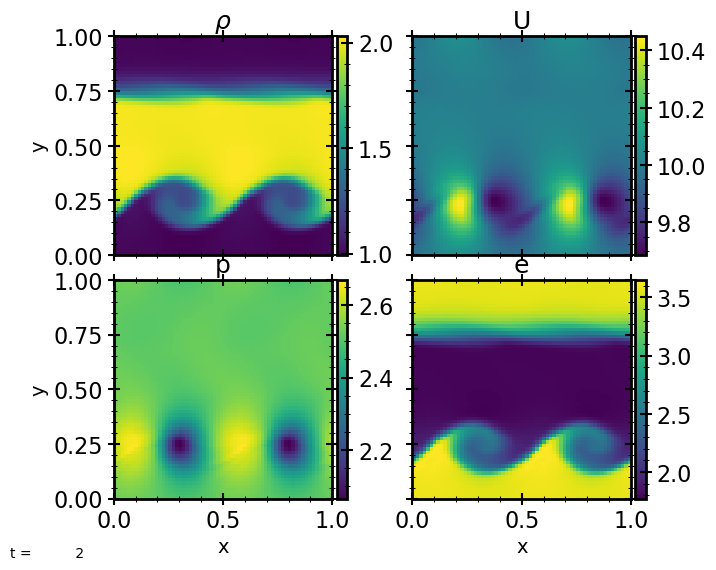

Simulation with gamma=1.7 and Delta U = 10 km/s using compressible_rk.


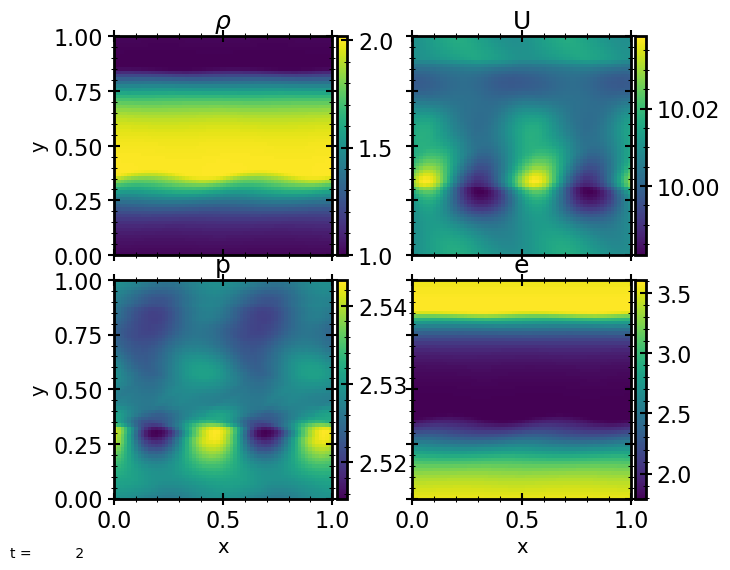

Simulation with gamma=1.7 and Delta U = 10 km/s using compressible_fv4.


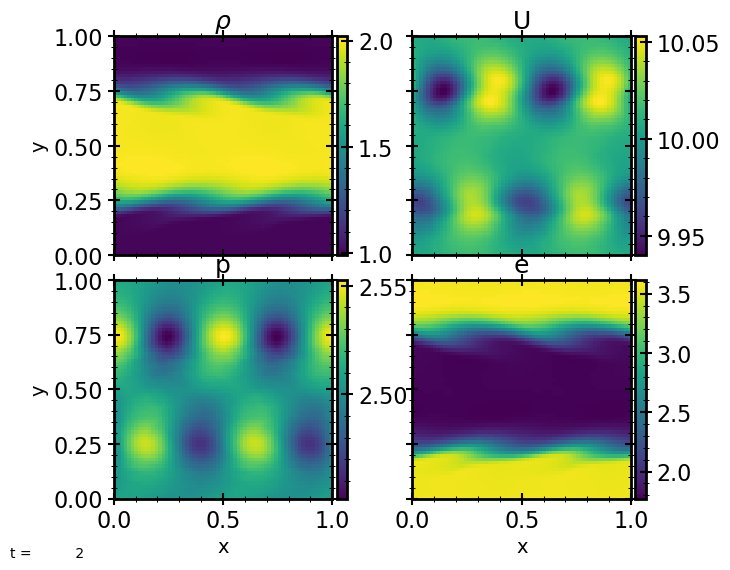

warning, key: compressible.limiter not defined
Simulation with gamma=1.7 and Delta U = 10 km/s using compressible_sdc.


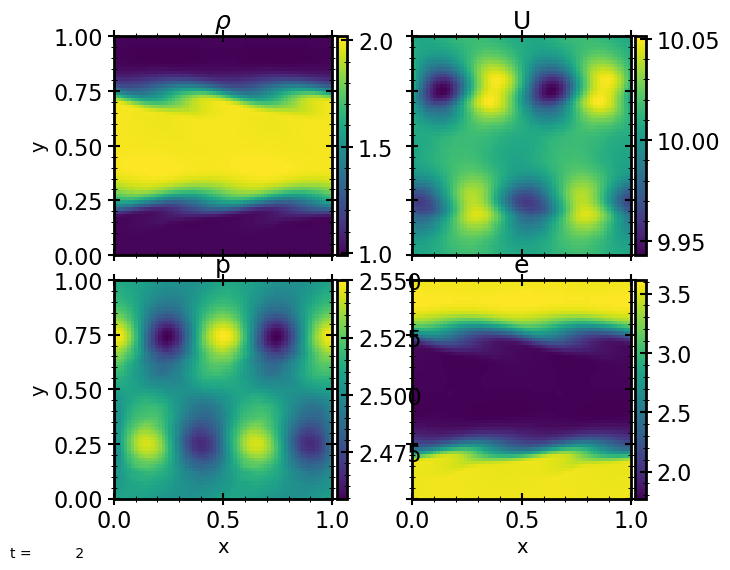

<Figure size 800x600 with 0 Axes>

In [3]:
second_solvers = ["compressible", "compressible_rk", "compressible_fv4", "compressible_sdc"]
second_problem_name = "kh"
second_param_file = "inputs.kh"
second_extra_parameters = {'eos.gamma': 1.7, 'kh.bulk_velocity': 10}

for solver in second_solvers:
    pyro_sim = Pyro(solver) #create a Pyro object
    pyro_sim.initialize_problem(second_problem_name, inputs_file=second_param_file, inputs_dict=second_extra_parameters) #initalize a Pyro object with the input parameters
    pyro_sim.run_sim() #time evolve the simulation
    print(f"Simulation with gamma=1.7 and Delta U = 10 km/s using {solver}.")
    pyro_sim.sim.dovis() #plot the results